# GeoBench SpaceNet7

In [1]:
import json
import os
from pathlib import Path

import torch

from geobench_v2.datamodules import GeoBenchSpaceNet7DataModule
from geobench_v2.datasets import GeoBenchSpaceNet7
from geobench_v2.datasets.data_util import ClipZScoreNormalizer, SatMAENormalizer
from geobench_v2.datasets.visualization_util import (
    compute_batch_histograms,
    plot_batch_histograms,
    plot_channel_histograms,
)

%load_ext autoreload
%autoreload 2

In [2]:
PROJECT_ROOT = Path("../../")

In [ ]:
band_order = GeoBenchSpaceNet7.band_default_order

datamodule = GeoBenchSpaceNet7DataModule(
    img_size=256,
    batch_size=16,
    num_workers=4,
    root=PROJECT_ROOT / "data" / "spacenet7",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(),  # we do custom normalization in the tutorial
)
datamodule.setup("fit")

Using provided pre-initialized normalizer instance: Identity
Using provided pre-initialized normalizer instance: Identity


Map extent: Longitude [-126.67° to 149.96°], Latitude [-42.52° to 57.49°]
Found 3 dataset splits: train, test, validation


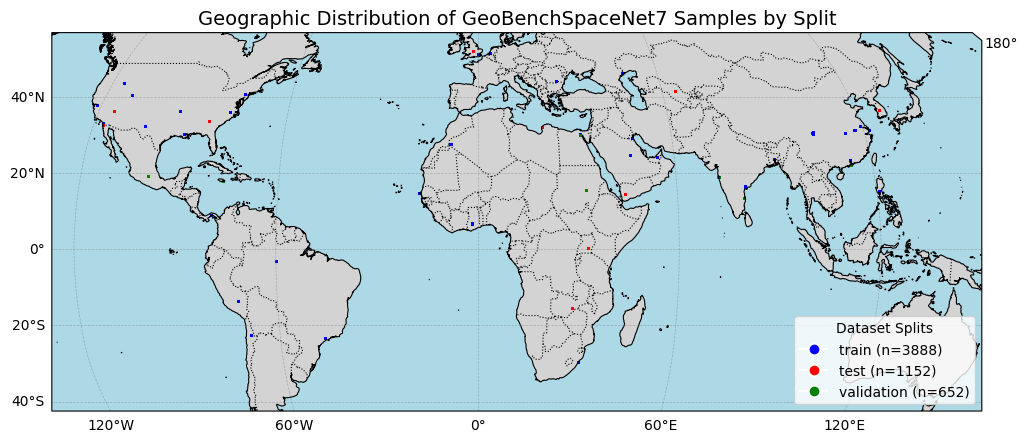

In [4]:
sample_dist_fig = datamodule.visualize_geospatial_distribution()

In [5]:
STATS_DIR = os.path.join(
    PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats"
)
STATS_WITH_CLIP_DIR = os.path.join(
    PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats_with_clip"
)

# Load dataset statistics from JSON files
direct_stats_path = os.path.join(STATS_DIR, "spacenet7", "spacenet7_stats.json")
satmae_stats_path = os.path.join(
    STATS_WITH_CLIP_DIR, "spacenet7", "spacenet7_stats.json"
)


def create_normalizer_from_stats(stats_path, normalizer_class, band_order):
    """Create a data normalizer from a stats JSON file."""
    with open(stats_path) as f:
        stats = json.load(f)

    means = {}
    stds = {}
    clip_min = {}
    clip_max = {}

    for modality, modality_stats in stats["input_stats"].items():
        bands = modality_stats["band_names"]
        mean_values = modality_stats["mean"]
        std_values = modality_stats["std"]

        if "clip_min_used" in modality_stats:
            clip_min[modality] = modality_stats["clip_min_used"]
        if "clip_max_used" in modality_stats:
            clip_max[modality] = modality_stats["clip_max_used"]

        for i, band in enumerate(bands):
            if i < len(mean_values) and i < len(std_values):
                means[band] = mean_values[i]
                stds[band] = std_values[i]

    norm_stats = {
        "means": means,
        "stds": stds,
        "clip_min": clip_min,
        "clip_max": clip_max,
    }
    print(norm_stats)

    # Create normalizer instance
    if normalizer_class == SatMAENormalizer:
        return normalizer_class(norm_stats, band_order, output_range="zero_one")
    else:
        return normalizer_class(norm_stats, band_order)


multimodal_normalizer = create_normalizer_from_stats(
    direct_stats_path, ClipZScoreNormalizer, band_order
)
satmae_normalizer = create_normalizer_from_stats(
    satmae_stats_path, SatMAENormalizer, band_order
)

{'means': {'red': 116.94474029541016, 'green': 103.55889129638672, 'blue': 76.77427673339844}, 'stds': {'red': 61.655845642089844, 'green': 49.64897537231445, 'blue': 45.88066864013672}, 'clip_min': {}, 'clip_max': {}}
{'means': {'red': 117.8301010131836, 'green': 104.57936096191406, 'blue': 77.57808685302734}, 'stds': {'red': 62.00752639770508, 'green': 49.81483459472656, 'blue': 46.078304290771484}, 'clip_min': {'image': 0}, 'clip_max': {'image': 255}}


### Raw Image Statistics

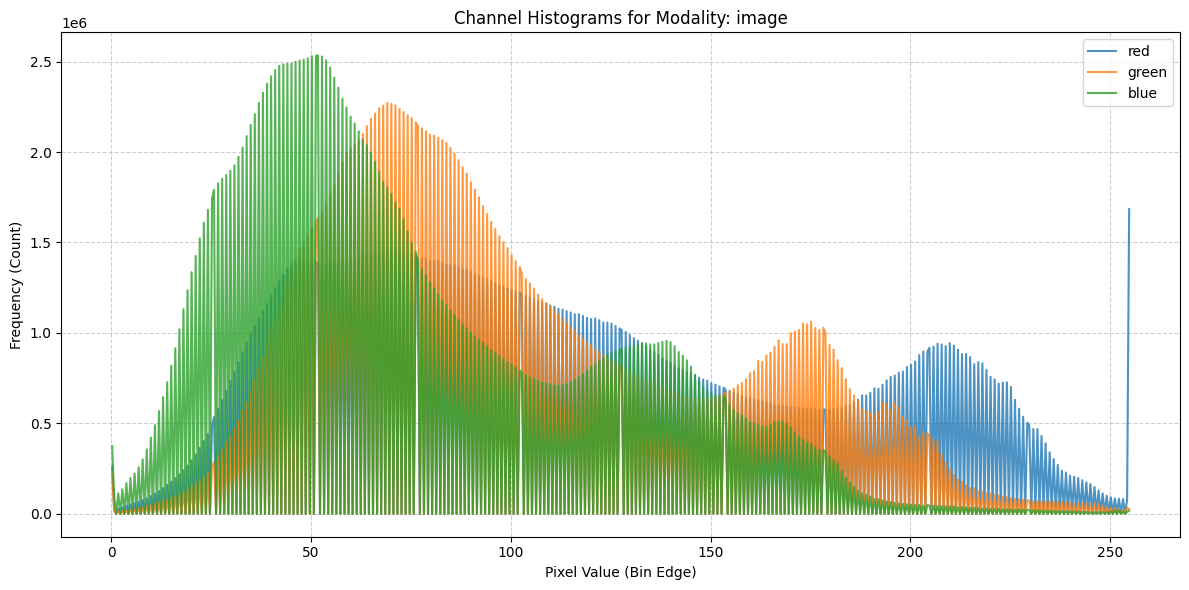

In [6]:
fig = plot_channel_histograms(
    "/home/nils/projects/GEO-Bench-2/geobench_v2/generate_benchmark/dataset_stats/spacenet7/spacenet7_stats.json"
)

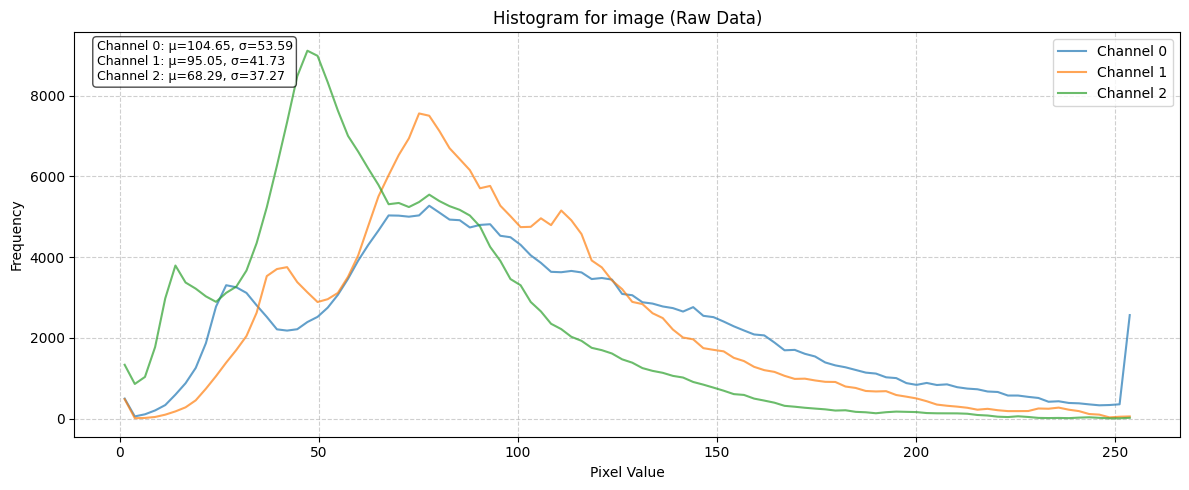

In [7]:
# Get a batch of data from the dataloader
train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))

raw_batch_stats = compute_batch_histograms(raw_batch, n_bins=100)

raw_figs = plot_batch_histograms(
    raw_batch_stats, band_order, title_suffix=" (Raw Data)"
)

In [8]:
satmae_normalizer.means.keys()

dict_keys(['image'])

[<Figure size 1200x500 with 1 Axes>]

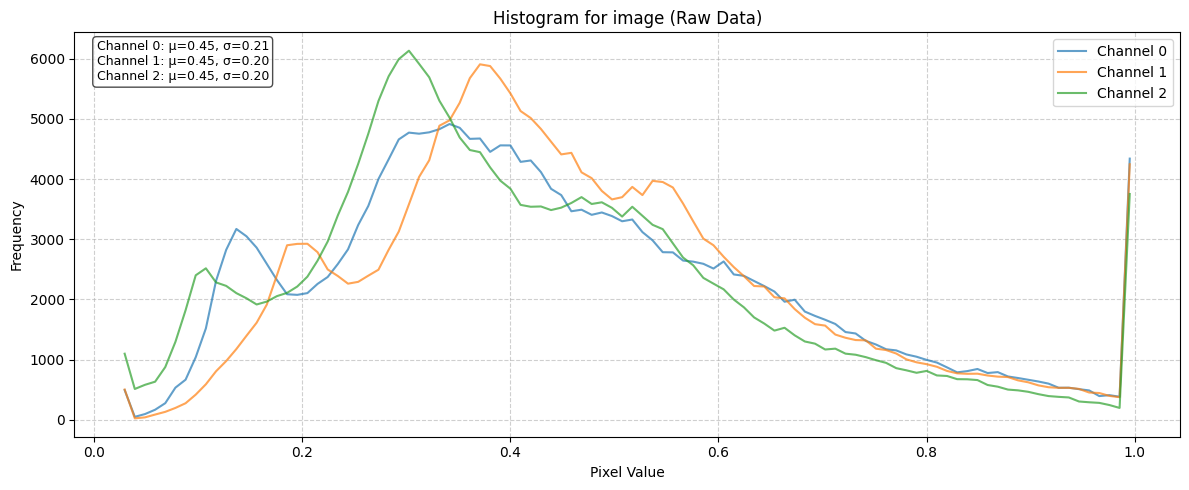

In [9]:
satmae_normalized_batch = satmae_normalizer(raw_batch)
satmae_batch_stats = compute_batch_histograms(satmae_normalized_batch, n_bins=100)
sat_mae_norm_fig = plot_batch_histograms(
    satmae_batch_stats, band_order, title_suffix=" (Raw Data)"
)
sat_mae_norm_fig

[<Figure size 1200x500 with 1 Axes>]

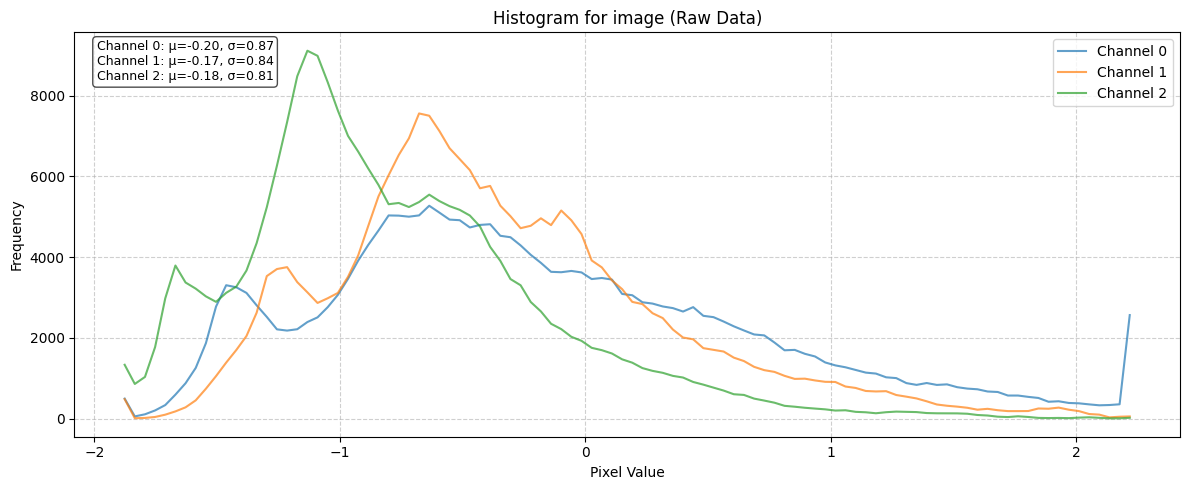

In [10]:
mn_normalized_batch = multimodal_normalizer(raw_batch)
mn_batch_stats = compute_batch_histograms(mn_normalized_batch, n_bins=100)
mn_norm_fig = plot_batch_histograms(
    mn_batch_stats, band_order, title_suffix=" (Raw Data)"
)
mn_norm_fig

## Visualize Batch

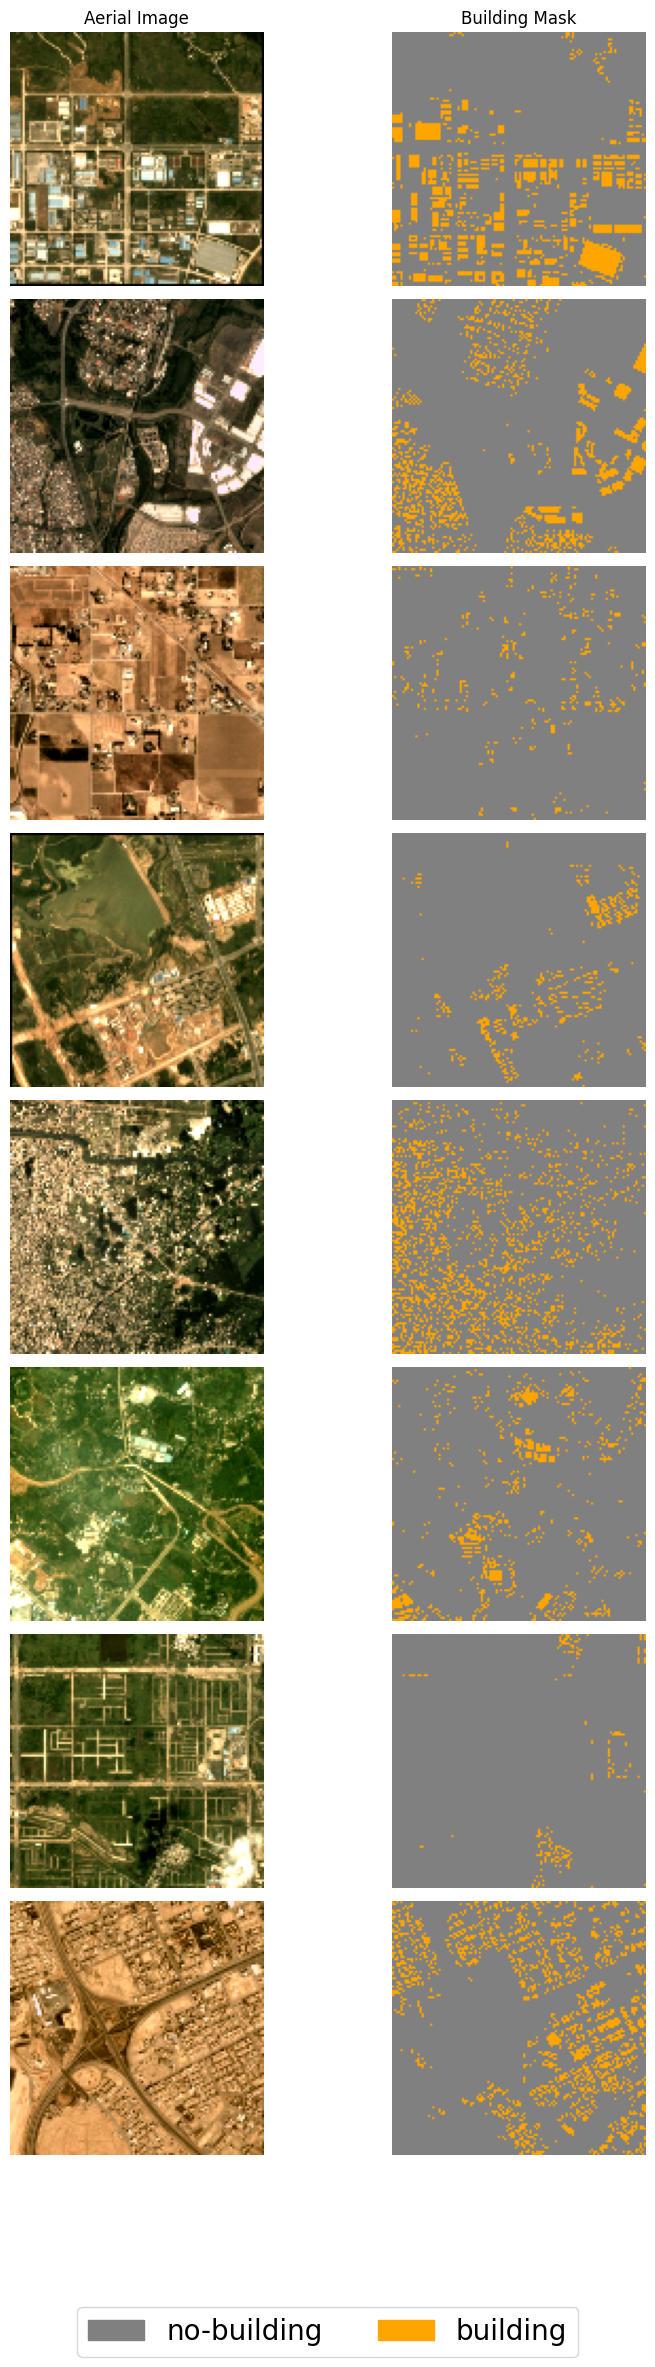

In [16]:
fig, batch = datamodule.visualize_batch()